# Dec 28th, 2022 (SLC: Carto)

**Motivation**: Create Cartography figure, and cartoon examples of blockmodels showing disjoint, sparse overlap, and dense overlap  <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

## Fig dir

In [2]:
nn = 512
perc = 15
fig_dir = 'Fig7_Carto'
fig_dir = pjoin(fig_base_dir, 'paper2.0', f'n{nn}-p{perc}', fig_dir)
os.makedirs(fig_dir, exist_ok=True)
print(fig_dir)

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/paper2.0/n512-p15/Fig7_Carto

## Prepare (512)

In [3]:
num_k = 7
perc = 15
mice = Mice(nn)
bt_dict, props_bo, props_ca = default_props(mice, num_k, perc)
bt = BootStrap(**props_ca)
pal = prepare_palette()

## Cartography

In [4]:
%%time

for mode, o in bt_dict.items():
    o.compute_entropy(
        use_prune=True,
        select_seeds=False,
    )
for mode, o in bt_dict.items():
    o.run_deg = np.array(o.run_deg)
    o.run_deg[o.run_deg == 0] = np.nan

CPU times: user 9.5 s, sys: 2.64 s, total: 12.1 s
Wall time: 12.1 s


In [5]:
d = perc / 100
good = git_good('deg', bt_dict)
mu = (0, good.sum() * d)

d, good.sum(), mu

(0.15, 530, (0, 79.5))

In [6]:
df = []
for mode, o in bt_dict.items():
    _ = o.compute_entropy()
    _df = o.mk_cartography_df(
        affil=bt.affil_included,
        n_resamples=int(1e2),
        mu=mu,
    )
    _df['mode'] = mode
    df.append(_df)
df = pd.concat(df)

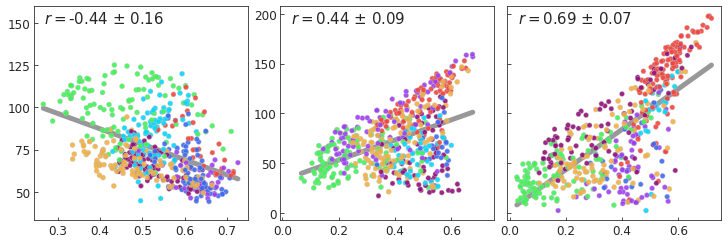

CPU times: user 2min 17s, sys: 804 ms, total: 2min 17s
Wall time: 2min 17s


In [7]:
%%time

from figures.fig_carto import cartography as go
fig, *_ = go(df, bt_dict, legend=False)

fig.savefig(pjoin(fig_dir, 'carto.pdf'), **kws_fig)
fig.savefig(pjoin(fig_dir, 'carto.png'), **kws_fig)

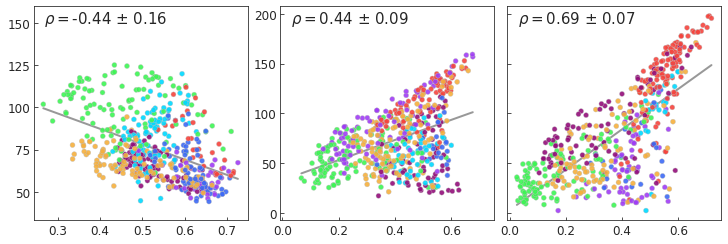

CPU times: user 2min 49s, sys: 854 ms, total: 2min 50s
Wall time: 2min 50s


## Create simulated blockmodels

In [3]:
from simulation.simulation import get_cartoon_types

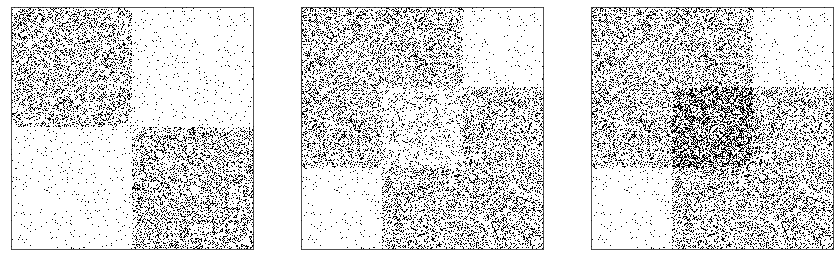

In [4]:
output = get_cartoon_types(
    size=300,
    ovp_ratio=3,
    thresh_bg=0.90,
    thresh_base=0.65,
    thresh_dense=0.53,
    thresh_sparse=0.75,
)
fig, axes = create_figure(1, 3, (12, 3.5), 'all', 'all', constrained_layout=True)
axes[0].imshow(output['disj'], cmap='Greys')
axes[1].imshow(output['sparse'], cmap='Greys')
axes[2].imshow(output['dense'], cmap='Greys')
remove_ticks(axes, False)
plt.show()

In [88]:
for k, x in output.items():
    fig, ax = create_figure(1, 1, (5,) * 2, constrained_layout=True)
    ax.imshow(x, cmap='Greys')
    remove_ticks(ax, False)
    fig.savefig(pjoin(fig_dir, f'cartoon_{k}.pdf'), **kws_fig)
    fig.savefig(pjoin(fig_dir, f'cartoon_{k}.png'), **kws_fig)
    plt.close()

## Save disjoint to use as key

In [90]:
_ = mice.parcel.load_parcel(True)

In [91]:
%%time

results = similiarity_results(
    mice=mice,
    perc=perc,
    num_k=num_k,
    n_resamples=None,
    merge_thres=0.444 if
    num_k == 7 else None,
)

CPU times: user 14.3 s, sys: 19.5 s, total: 33.8 s
Wall time: 1min 8s


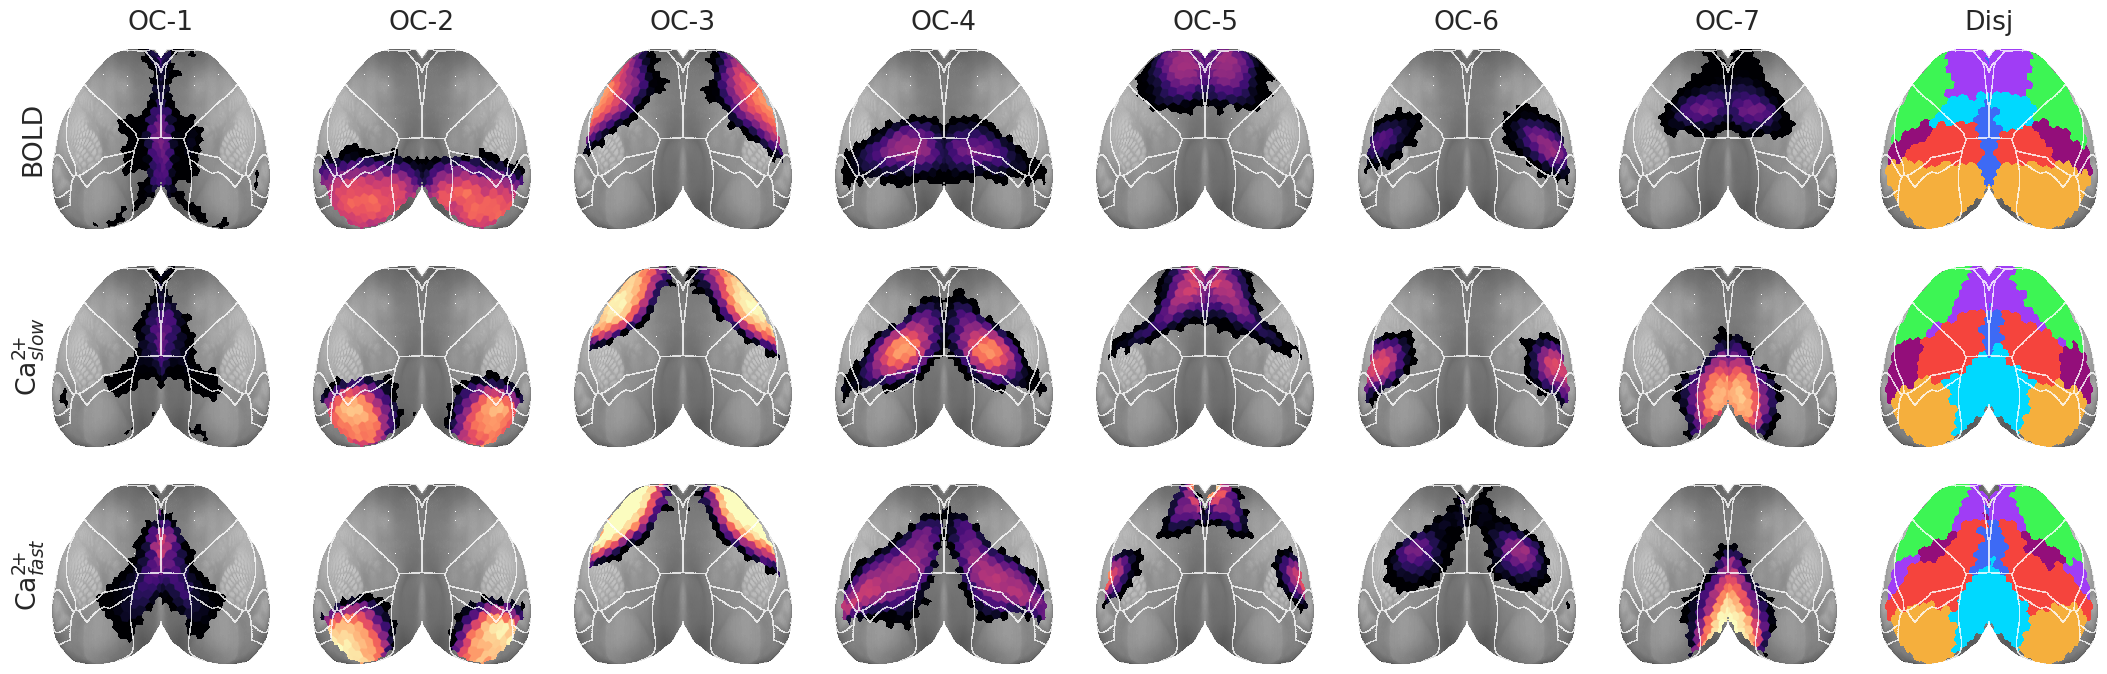

In [92]:
_ = bt.show(results['pi_sorted'], **show_kws(num_k))

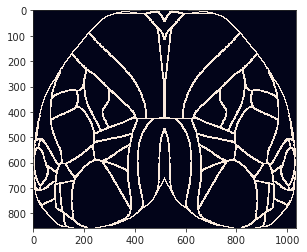

In [93]:
contour = bt.get_contour(0.2, False)
plt.imshow(contour);

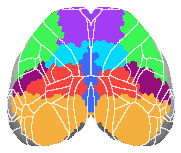

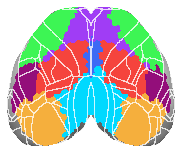

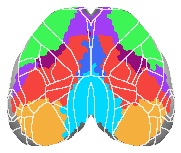

In [98]:
mode2lbl = {BOLD: 'BOLD', CAS: 'CAS', CAF: 'CAF'}
for mode, pi in results['pi_sorted'].items():
    partition = bt.get_disjoint_community(pi)

    fig, ax = create_figure(figsize=(3, 3.2))
    ax, _ = ctx2ax(
        ax,
        bt,
        partition,
        cmap=bt.cmaps[-1],
        contour=contour,
        vmin=1,
        vmax=num_k,
        cbar=False,
        interp='none',
    )
    remove_ticks(ax)
    
    fig.savefig(pjoin(fig_dir, f'Disj_{mode2lbl[mode]}.png'), **kws_fig)
    plt.show()